# Simple Neural Network from Scratch
### Tomer Eldor
#### TT Deep Learning 1 
#### Oct 2018

## Import Libraries and Data

In [7]:
# Import Libraries and Data
import numpy as np
from sklearn.datasets import fetch_mldata # for importing the dataset only
import matplotlib.pyplot as plt
%matplotlib inline

dataset = fetch_mldata('MNIST original')
X_full, y_full = dataset['data'], dataset['target']

/Users/tomer/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/tomer/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


## Preprocess Data

In [58]:
### PREPROCESS DATA ###
n_classes = 10

# Reduce to a susbsample (while working on the code)
SUBSAMPLE_SIZE = 50000 # choose how many samples for now
subsample_idx = np.random.choice(X_full.shape[0], SUBSAMPLE_SIZE) # array of indices of subsample
X, y = X_full[subsample_idx], y_full[subsample_idx]

# Shuffle X and Y for random sampling
index_random = np.random.permutation(X.shape[0])
X, y = X[index_random], y[index_random]
n_train_samples = int(0.75*SUBSAMPLE_SIZE)


# Preprocess inputs and outputs
def preprocess_bw_image(x):
    '''Normalizes pixel values to be between 0 and 1 instead of 0–255'''
    return x/255.0
X_processed = preprocess_bw_image(X)

def onehot(y, n_classes):
    '''Reshapes y to a one-hot coding and flips the matrix shape to fit later calculations'''
    return np.eye(n_classes)[y.astype('int')] 
y_onehot = onehot(y, n_classes) # convert y to one-hot encoding, to compare with y_pred (for loss function)

# Divide into Training and Test Samples and Flip matrices for later computations
X_train, X_test = X_processed[:n_train_samples].T, X_processed[n_train_samples:].T
Y_train, Y_test = y_onehot[:n_train_samples].T, y_onehot[n_train_samples:].T

# Build Neural Network Class

In [62]:
# NEURAL NETWORK MLP CLASS

class neural_net_mlp:
    
    def __init__(self, X, Y, n_hidden_nodes = 15, n_classes = 10, learning_rate = 0.5):
        ''' 
        Initializaing MLP Neural Network with one input layer, one hidden layer, and output layer.
        Arguments:
            X - inputs (training). shape: (N_features, N_samples) (*features = pixels here)
            Y - output labels of X_training, one-hot encoded. shape (N_classes, N_samples)
            n_hidden_nodes - number of neurons in the hidden layer 
            n_classes - number of possible classes for Y
            learning_rate - rate at which the network will train (in gradient descent)
        '''
        # initializing self NN parameters
        self.X = X
        self.Y = Y
        self.n_hidden_nodes = n_hidden_nodes
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.n_X_nodes = X.shape[0] # length of features/pixels of each observation
        # Initialize Weights and Biases
        self.Weights1 = np.random.normal(0, 1, size=(self.n_hidden_nodes, self.n_X_nodes))
        self.biases1 = np.random.normal(0, 1, size=(self.n_hidden_nodes, 1))
        self.Weights2 = np.random.normal(0, 1, size=(self.n_classes, self.n_hidden_nodes))
        self.biases2 = np.random.normal(0, 1, size=(self.n_classes, 1))
    
    
    ## Helper Math Functions
    
    def loss_function(self, y_true, y_pred):
        ''' 
        Using multiclass cross entropy as a loss function
        (since we have multiclass output)
        Input: y_true, y_pred - vectors of same shape
        Returns: result of multiclass cross entropy between them (float)
        '''
        loss = np.sum(np.multiply(y_true, np.log(y_pred)))
        return -(1/y_true.shape[0]) * loss

    def sigmoid(self, x):
        ''' simple sigmoid function as our activation function of Layer 0 and 1'''
        return (1 / (1 + np.exp(-x)))
    
    def sigmoid_derivative(self, Z):
        ''' derivative of the sigmoid function for backpropagation'''
        sig = self.sigmoid(Z)
        return sig * (1 - sig)

    def softmax(self, x):
        ''' Softmax activation function. Applies softmax to the input x.
        (Its advantage is that it returns a vector of probabilities that sum up to 1)
        Arguments:
            - x: any vector
        Returns:
            - softmax(x) - vector of the same shape'''
        exps_x = np.exp(x)
        return exps_x / np.sum(exps_x, axis=0) 

    
    ## Nerual Network functions
    
    def fc_layer(self, inputs, weights, biases):
        '''
        Fully Connected Layer of MLP/NN: y = wx + b (weights*input + biases), 
        that fed into the activation function, so that y = activation(wx+b)
        Arguments:
             - inputs: input data for the layer - either the initial input for the net
                        or the ouput of the previous (lower) layer (np array of floats)
             - weights: set of weights for that layer's connections (np array of floats)
             - biases: set of biases for that layer's connections (np array of floats)
        Returns:
            Z: the result of the matrix multiplication of weights with previous layer's activations
        '''
        return np.matmul(weights, inputs) + biases

    def feed_forward(self, X):
        '''
        Constructs the NNet with 1 hidden layer and 1 output layer
        Feeds forward from the initial (preprocessed) input through those layers, generates prediction
        Arguments:
            - X: the input data for the network (numpy array of floats). size: (n_pixles (or features), n_observations)
            - Weights1 - initial values for weights of the first layer. np array of size: (n_hidden_nodes, n_initial_input_nodes)
            - biases1 - initial values for biases. vector of length: n_hidden_nodes
            - Weights2 - initial values for weights of the first layer. np array of size: (n_output_nodes, n_hidden_nodes)
            - biases2 - initial values for biases. vector of length: n_output_nodes
        Returns:
            - y_pred - prediction probability for each observation for each class
            - Z1: result of the fully connecter layer 1 (y=wx+b, before activation), needed for later gradient/derivatives
            - A1: result of Z1 after the activation function, needed for backpropagation later
        '''
        # FEED-FORWARD 
        # layer 0 - input layer
        self.A0 = X # allowing flexible input for prediction
        # layer 1 - hidden layer
        Z1 = self.fc_layer(self.A0, self.Weights1, self.biases1)
        A1 = self.sigmoid(Z1)
        # layer 2 - output layer
        Z2 = self.fc_layer(A1, self.Weights2, self.biases2)
        # for the last layer, we'll yse softmax as the activation function 
        # to output probabilities summing up to 1 (for above 2 classes)
        y_pred = self.softmax(Z2)
        return y_pred, Z1, A1 # Z1 & A1 needed for backpropagation

    def gradients_WB(self, dZ, x):
        ''' 
        Calculates the derivatives with respect to the weights and biases.
        See https://www.deeplearningbook.org/contents/mlp.html, page 209
        Arguments:
            dZ: derivative with respect to Z of that layer (depends on the activation)
            X: training examples used
            n_train_samples = number of training 
        Returns:
            Gradient for weights, gradient for biases
        '''
        n_obs = self.X.shape[0]
        dWeights = (1.0/n_obs) * np.matmul(dZ, x.T)
        dBiases = (1.0/n_obs) * np.sum(dZ, axis=1, keepdims=True)
        return dWeights, dBiases


    ## TRAIN THE NETWORK 
    
    def train(self, n_epochs = 100, n_prints = 10, showprint = True, showplot = True):
        ''' Train the NNet
        Arguments:
            - n_epochs: number of repetitions for the training process (int)
            - n_prints: number of epochs to save and plot or print their cost function (int)
            - showprint: print cost function lines or not (Boolean)
            - showplot: display plot of loss function over time or not (Boolean)
        Returns:
            final Cost value from loss function (float)
            Trains the network internally (self.weights and biases), outputs prints and plots if desired
        '''
        # initialize and save training parameters info
        self.costs = []
        self.n_epochs = n_epochs 
        epoch_ids = []
        # TRAIN
        if showprint: print("Training MLP Neural Network with 1 hidden layer of {} neurons for {} epochs".format(self.n_hidden_nodes, self.n_epochs))
        for i in range(1, n_epochs+1):
            # FEED-FORWARD 
            y_pred, Z1, A1 = self.feed_forward(self.X)
            # calculate cost using the loss function
            cost = self.loss_function(self.Y, y_pred)

            # BACKPROPAGATION - gradient calculations
            # derivatives of Layer 2: 
            dZ2 = y_pred - self.Y # simple error
            dWeights2, dBiases2 = self.gradients_WB(dZ2, A1)
            # derivatives of Layer 1
            dA1 = np.matmul(self.Weights2.T, dZ2) # derivative of A1 
            dZ1 = dA1 * self.sigmoid_derivative(Z1) # derivative of Z1: derivative of A1 and sigmoid derivative of Z1
            dWeights1, dBiases1 = self.gradients_WB(dZ1, self.X)

            # Update the weights and biases
            self.Weights2 -= self.learning_rate * dWeights2
            self.biases2 -=  self.learning_rate * dBiases2
            self.Weights1 -= self.learning_rate * dWeights1
            self.biases1 -=  self.learning_rate * dBiases1

            # (print) and save cost results
            if i == 1 or (i % int(self.n_epochs / n_prints) == 0) or i == n_epochs:
                if showprint: print("Cost at Epoch {}: \t {}".format(i, cost))
                self.costs.append(cost)
                epoch_ids.append(i)
        
        # Summarize and plot costs
        if showplot:
            plt.plot(epoch_ids, self.costs)
            plt.xlabel('Epochs')
            plt.ylabel('Loss (Multiclass Cross-Entropy)')
            plt.title('NN Loss function during training epochs')
            plt.show()
        
        return cost

# Training the Network

Training MLP Neural Network with 1 hidden layer of 15 neurons for 5000 epochs
Cost at Epoch 1: 	 3599.0708866008354
Cost at Epoch 250: 	 245.81861380031089
Cost at Epoch 500: 	 168.18777157251407
Cost at Epoch 750: 	 131.2072820412647
Cost at Epoch 1000: 	 108.71133635316615
Cost at Epoch 1250: 	 93.41058010598938
Cost at Epoch 1500: 	 81.79485595174926
Cost at Epoch 1750: 	 72.72274793832061
Cost at Epoch 2000: 	 65.5158967334727
Cost at Epoch 2250: 	 59.46187949431132
Cost at Epoch 2500: 	 54.74235842770605
Cost at Epoch 2750: 	 50.46233552636417
Cost at Epoch 3000: 	 46.75588986241054
Cost at Epoch 3250: 	 44.08113507929413
Cost at Epoch 3500: 	 41.619689589631825
Cost at Epoch 3750: 	 39.45992866362695
Cost at Epoch 4000: 	 37.378319040566105
Cost at Epoch 4250: 	 35.191362257890965
Cost at Epoch 4500: 	 33.76120534615713
Cost at Epoch 4750: 	 32.32027328313764
Cost at Epoch 5000: 	 31.048684652495055


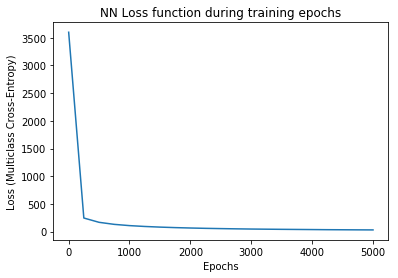

In [18]:
# Initialize a Neural Network (MLP) object
nn = neural_net_mlp(X_train, Y_train, n_hidden_nodes = 15, n_classes = 10, learning_rate = 0.5)
nn.train(n_epochs = 5000, n_prints = 20, showprint = 1, showplot = 1)

# Testing the Model

In [57]:
y_pred, _Z1, _A1 = nn.feed_forward(X_test)
cost = nn.loss_function(Y_test, y_pred)
print("Loss of test set: ", cost)

Loss of test set:  123.02190720993393


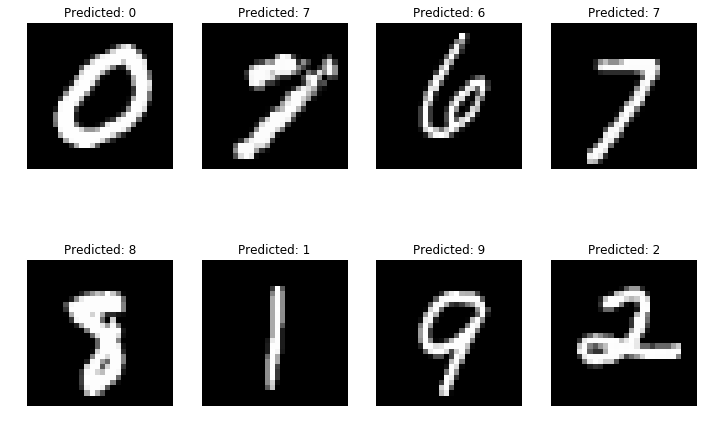

In [56]:
# Show results with visual predictions
def print_image_and_prediction(i, samples, X_test, y_pred):
    example = X_test[:, samples[i]].reshape(28,28)
    plt.imshow(example, cmap = plt.cm.gray)
    predicted_result = np.argmax(y_pred[:,samples[i]])
    plt.title("Predicted: {}".format(predicted_result))
    plt.axis("off")
    
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
samples = np.random.randint(X_test.shape[1], size = 10) #draw some random samples to plot
for i in range(1, 9):
    ax = fig.add_subplot(2, 4, i) # 2 rows with 4 images (cols)
    print_image_and_prediction(i, samples, X_test, y_pred)

# Conclusion

The model seems to have trained successfully, as seen by the cost being reduced as expected (steep decrease initially, with later a less steep slope). 
The cost of the same model for the test set was higher than the final cost of the training set, so we might have overfitted. 
I have tried to increase the subsample size from 10K to 50K, train it again for less epochs searching for a balance cost between train and test samples, varying the number of nodes in the hidden layer and the learning rate.
Finding the best combination of those would be ideal and can be done using a grid search through many values of each. Below is a smaller test searching through multiple values of each.

## Further Calibrating
*This I continued on my own to explore better parameters *

In [63]:
model_results = []
for hiddens in [15,64,100]:
    for alpha in [0.1, 1, 10]:
        for n_epochs in [1000,5000]:
            print("Training an MLP with {} hidden nodes and learning rate of {}, for {} epochs".format(hiddens, alpha, n_epochs))
            nn = neural_net_mlp(X_train, Y_train, n_hidden_nodes = hiddens, n_classes = 10, learning_rate = alpha)
            training_cost = nn.train(n_epochs = n_epochs, n_prints = 20, showprint = 0, showplot = 0)
            y_pred, _Z1, _A1 = nn.feed_forward(X_test)
            test_cost = nn.loss_function(Y_test, y_pred)
            print("Training loss: {}, Test loss: {} - for MLP with {} hidden nodes, learning rate = {}, trained for {} epochs".format(training_cost, test_cost, hiddens, alpha, n_epochs))
            model_results.append([hiddens, alpha, n_epochs, training_cost, test_cost])


Training an MLP with 15 hidden nodes and learning rate of 0.1, for 500 epochs
Training loss: 1139.3299834088782, Test loss: 431.3432909762559 - for MLP with 15 hidden nodes, learning rate = 0.1, trained for 500 epochs
Training an MLP with 15 hidden nodes and learning rate of 0.1, for 1000 epochs
Training loss: 962.4741105713491, Test loss: 387.89927148871357 - for MLP with 15 hidden nodes, learning rate = 0.1, trained for 1000 epochs
Training an MLP with 15 hidden nodes and learning rate of 0.1, for 5000 epochs
Training loss: 464.48229967370656, Test loss: 323.447861528466 - for MLP with 15 hidden nodes, learning rate = 0.1, trained for 5000 epochs
Training an MLP with 15 hidden nodes and learning rate of 1, for 500 epochs
Training loss: 23589.764502253624, Test loss: 6102.375646366163 - for MLP with 15 hidden nodes, learning rate = 1, trained for 500 epochs
Training an MLP with 15 hidden nodes and learning rate of 1, for 1000 epochs
Training loss: 25873.04401913751, Test loss: 7820.97

/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply
/Users/tomer/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


Training loss: nan, Test loss: nan - for MLP with 15 hidden nodes, learning rate = 10, trained for 500 epochs
Training an MLP with 15 hidden nodes and learning rate of 10, for 1000 epochs
Training loss: nan, Test loss: nan - for MLP with 15 hidden nodes, learning rate = 10, trained for 1000 epochs
Training an MLP with 15 hidden nodes and learning rate of 10, for 5000 epochs
Training loss: nan, Test loss: nan - for MLP with 15 hidden nodes, learning rate = 10, trained for 5000 epochs
Training an MLP with 64 hidden nodes and learning rate of 0.1, for 500 epochs
Training loss: 737.2620313710697, Test loss: 315.6828725082976 - for MLP with 64 hidden nodes, learning rate = 0.1, trained for 500 epochs
Training an MLP with 64 hidden nodes and learning rate of 0.1, for 1000 epochs
Training loss: 488.99439009616566, Test loss: 271.09940639612523 - for MLP with 64 hidden nodes, learning rate = 0.1, trained for 1000 epochs
Training an MLP with 64 hidden nodes and learning rate of 0.1, for 5000 ep

KeyboardInterrupt: 

^ 

*I Stopped the above process in the middle to improve parameters again
The above process showed that loss was best the smaller the learning rate was (0.1) and the more epochs.
That makes sense because the smaller the learning rate, the more sensitive the network is to find the best direction in the gradient to descend to and doesn't 'jump' over the local minima, so the cost should go down more smoothly and consistently, still if more slowly. Therefore, the more iterations (epochs) we have, the more time the NN has to callibrate its weights and biases and descend the gradient, to decrease the cost.

Therefore, I'll explore more around that space.

In [ ]:
# Storing results
model_results = []
y_preds_first_hundred = []
for hiddens in [15,64,100]:
    for alpha in [0.01, 0.1, 0.5]:
        for n_epochs in [1000,5000]:
            print("Training MLP with {} hidden nodes and {} learning rate, for {} epochs".format(hiddens, alpha, n_epochs))
            nn = neural_net_mlp(X_train, Y_train, n_hidden_nodes = hiddens, n_classes = 10, learning_rate = alpha)
            training_cost = nn.train(n_epochs = n_epochs, n_prints = 20, showprint = 0, showplot = 0)
            y_pred, _Z1, _A1 = nn.feed_forward(X_test)
            test_cost = nn.loss_function(Y_test, y_pred)
            print("\t Training loss: {}, Test loss: {} - \n\t MLP with {} hidden nodes, learning rate = {}, {} epochs \n\n".format(training_cost, test_cost, hiddens, alpha, n_epochs))
            model_results.append([hiddens, alpha, n_epochs, training_cost, test_cost])
            y_preds_first_hundred.append(y_pred[:,:100])
            
## Stopped this in the middle to optimize parameters again

Training MLP with 15 hidden nodes and 0.01 learning rate, for 1000 epochs
	 Training loss: 2100.2401974618147, Test loss: 716.3888629346984 - 
	 MLP with 15 hidden nodes, learning rate = 0.01, 1000 epochs 


Training MLP with 15 hidden nodes and 0.01 learning rate, for 5000 epochs
	 Training loss: 1124.557277104484, Test loss: 431.56013769511776 - 
	 MLP with 15 hidden nodes, learning rate = 0.01, 5000 epochs 


Training MLP with 15 hidden nodes and 0.1 learning rate, for 1000 epochs
	 Training loss: 888.2159500833876, Test loss: 372.96537013681314 - 
	 MLP with 15 hidden nodes, learning rate = 0.1, 1000 epochs 


Training MLP with 15 hidden nodes and 0.1 learning rate, for 5000 epochs
	 Training loss: 396.4551560335651, Test loss: 288.79037963528236 - 
	 MLP with 15 hidden nodes, learning rate = 0.1, 5000 epochs 


Training MLP with 15 hidden nodes and 0.5 learning rate, for 1000 epochs
	 Training loss: 1764.435705561902, Test loss: 684.5704487811058 - 
	 MLP with 15 hidden nodes, lea